In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def running_avg(x):
    return np.cumsum(x) / np.arange(1, x.size + 1)

def running_timeavg(t,x):
    dt = t[1:] - t[:-1]
    x = np.cumsum(x[:-1] * dt)
    y = t[1:]
    return [a/b for a,b in zip(x,y)]

def filter_vec(df, name):
    x = df[(df.name == name + ":vector") & (df.type == "vector")] #.filter(["vectime","vecvalue"])
    return x #pd.DataFrame(index=x.vectime.values[0], data={name : x.vecvalue.values[0]})
    
#for i in range(1,len(vec)):
#    row = vec.iloc[i]
#    row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
#    mean_res = pd.concat((mean_res, row)    
#mean_res = mean_res_dc.groupby(level=0).mean()

## Caso DC - Recursos

In [2]:
# Cargamos los datos
targetDcRes = pd.read_csv("targetDcRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetDcRes[targetDcRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
123,targetDc-0-20250510-20:45:55-55496,vector,BigNet.dc.resourceManager,allocatedVms:vector,NaN,None,"[0.972261965548, 0.972550277918, 0.97290221307...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
127,targetDc-0-20250510-20:45:55-55496,vector,BigNet.dc.resourceManager,allocatedCores:vector,NaN,None,"[0.972261965548, 0.972550277918, 0.97290221307...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
131,targetDc-0-20250510-20:45:55-55496,vector,BigNet.dc.resourceManager,allocatedRam:vector,NaN,None,"[0.972261965548, 0.972550277918, 0.97290221307...","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
136,targetDc-0-20250510-20:45:55-55496,vector,BigNet.dc.resourceManager,allocatedDisk:vector,NaN,None,"[0.972261965548, 0.972550277918, 0.97290221307...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...."


In [3]:
def process_vector(df, data_name: str):
    # Empezamos el proceso de merging del conjunto de datos
    row = df.iloc[0]
    print(type(row.vectime))
    print(type(row.vecvalue))
    
    times = np.append([0], row.vectime)
    times = np.append(times, [3600])
    
    # Accumulate the values
    values = np.cumsum(row.vecvalue)
    values = np.append([0], values)
    values = np.append(values, max(values))
    
    vec = pd.DataFrame(index=times, data={data_name : values})
    
    return vec

In [4]:
res_dc = dict()
res_dc["vms"] = process_vector(filter_vec(targetDcRes, "allocatedVms"), "vms")
res_dc["ram"] = process_vector(filter_vec(targetDcRes, "allocatedRam"), "ram")
res_dc["disk"] = process_vector(filter_vec(targetDcRes, "allocatedDisk"), "disk")
res_dc["cpus"] = process_vector(filter_vec(targetDcRes, "allocatedCores"), "cpus")
res_dc["vms"]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,vms
0.000000,0.0
0.972262,1.0
0.972550,2.0
0.972902,3.0
0.978514,4.0
...,...
4.222664,97.0
4.226915,98.0
4.236976,99.0
4.236976,100.0


## Gráficas

In [5]:
dc_num_blades = 40
dc_max_vms = dc_num_blades*16
dc_max_ram = dc_num_blades*64
dc_max_disk = dc_num_blades*4000
dc_max_cpus = dc_num_blades*16

In [6]:
def plot_under_curve(axis, x, y ,color):
    axis.plot(x,y, color=color)
    axis.fill_between(x,y.reshape(-1),0, color=color, alpha=.1)

In [7]:
def plot_box(title,axis_title, x, y, color):
    fig, ax = plt.subplots(figsize=(4,3))
    plt.tight_layout()
    plot_under_curve(ax, x, y, color)
    ax.set(ylabel=axis_title)
    ax.set(xlabel='Tiempo de simulación (s)')
    ax.set_ylim(0,100)
    ax.set_xlim(0,3600)
    fig.savefig(title, bbox_inches='tight')

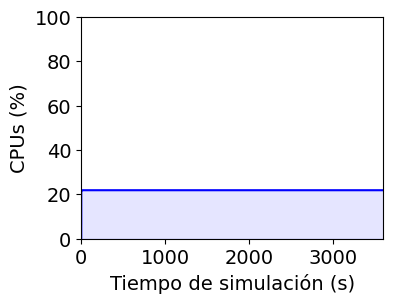

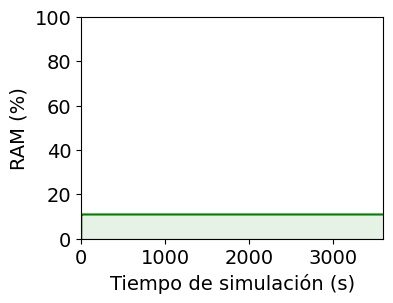

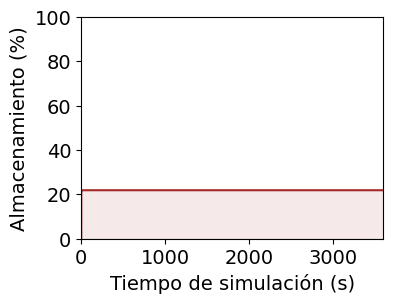

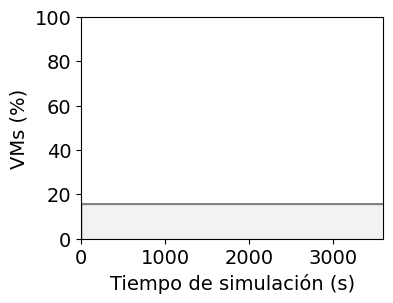

In [8]:
plot_box("bigResDcCpu.pdf", 'CPUs (%)', res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_cpus) * 100, "blue")
plot_box("bigResDcRam.pdf", 'RAM (%)', res_dc["ram"].index, (res_dc["ram"].values / dc_max_ram) * 100, "green")
plot_box("bigResDcDisk.pdf", 'Almacenamiento (%)', res_dc["disk"].index, (res_dc["disk"].values / dc_max_disk) * 100, "brown")
plot_box("bigResDcVms.pdf", 'VMs (%)', res_dc["vms"].index, (res_dc["vms"].values / dc_max_vms) * 100, "gray")

## Caso Fog - Recursos

In [9]:
# Cargamos los datos
targetDcRes2 = pd.read_csv("targetFogRes2.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

res_dc2 = dict()
res_dc2["vms"] = process_vector(filter_vec(targetDcRes2, "allocatedVms"), "vms")
res_dc2["ram"] = process_vector(filter_vec(targetDcRes2, "allocatedRam"), "ram")
res_dc2["disk"] = process_vector(filter_vec(targetDcRes2, "allocatedDisk"), "disk")
res_dc2["cpus"] = process_vector(filter_vec(targetDcRes2, "allocatedCores"), "cpus")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


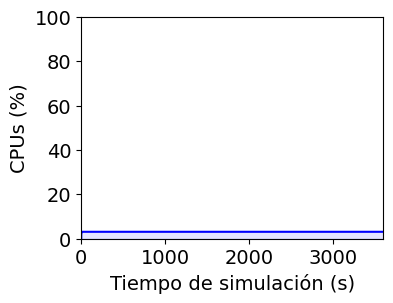

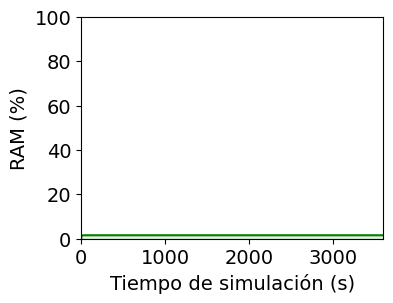

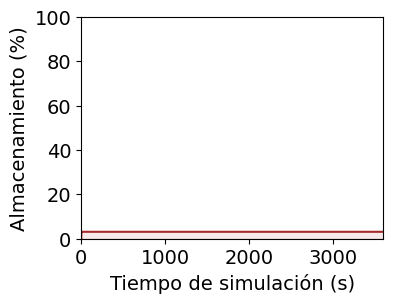

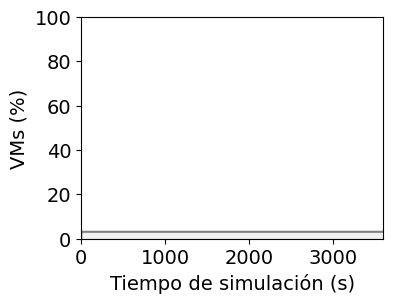

In [10]:
plot_box("bigResFogCpu2.pdf", 'CPUs (%)', res_dc2["cpus"].index, (res_dc2["cpus"].values / dc_max_cpus) * 100, "blue")
plot_box("bigResFogRam2.pdf", 'RAM (%)', res_dc2["ram"].index, (res_dc2["ram"].values / dc_max_ram) * 100, "green")
plot_box("bigResFogDisk2.pdf", 'Almacenamiento (%)', res_dc2["disk"].index, (res_dc2["disk"].values / dc_max_disk) * 100, "brown")
plot_box("bigResFogVms2.pdf", 'VMs (%)', res_dc2["vms"].index, (res_dc2["vms"].values / dc_max_vms) * 100, "gray")

In [11]:
# Cargamos los datos
targetFogRes = pd.read_csv("targetFogRes1.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetFogRes[targetFogRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,vectime,vecvalue
127,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD2.resourceManager,allocatedVms:vector,NaN,None,"[1.03460088893, 1.313712110461, 1.438003872316...","[1.0, 1.0, 1.0, 1.0, 1.0]"
131,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD2.resourceManager,allocatedCores:vector,NaN,None,"[1.03460088893, 1.313712110461, 1.438003872316...","[4.0, 1.0, 1.0, 1.0, 1.0]"
135,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD2.resourceManager,allocatedRam:vector,NaN,None,"[1.03460088893, 1.313712110461, 1.438003872316...","[8.0, 2.0, 2.0, 2.0, 2.0]"
140,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD2.resourceManager,allocatedDisk:vector,NaN,None,"[1.03460088893, 1.313712110461, 1.438003872316...","[1000.0, 250.0, 250.0, 250.0, 250.0]"
145,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgC2.resourceManager,allocatedVms:vector,NaN,None,"[1.042880298471, 1.315446690485, 1.44790449340...","[1.0, 1.0, 1.0, 1.0, 1.0]"
149,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgC2.resourceManager,allocatedCores:vector,NaN,None,"[1.042880298471, 1.315446690485, 1.44790449340...","[4.0, 1.0, 1.0, 1.0, 1.0]"
153,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgC2.resourceManager,allocatedRam:vector,NaN,None,"[1.042880298471, 1.315446690485, 1.44790449340...","[8.0, 2.0, 2.0, 2.0, 2.0]"
158,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgC2.resourceManager,allocatedDisk:vector,NaN,None,"[1.042880298471, 1.315446690485, 1.44790449340...","[1000.0, 250.0, 250.0, 250.0, 250.0]"
163,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD3.resourceManager,allocatedVms:vector,NaN,None,"[1.044029427315, 1.313783051804, 1.45025000940...","[1.0, 1.0, 1.0, 1.0, 1.0]"
167,targetFog-0-20250510-20:45:52-55490,vector,BigNet.fgD3.resourceManager,allocatedCores:vector,NaN,None,"[1.044029427315, 1.313783051804, 1.45025000940...","[4.0, 1.0, 1.0, 1.0, 1.0]"


In [12]:
def merge_process_vector(vec, data_name):
    #row = vec.iloc[0]
    agg = pd.DataFrame(index=[0], data={data_name : 0.0})
    
    for i in range(0,len(vec)):
        row = vec.iloc[i]
        row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
        agg = pd.concat((agg, row))
    agg = agg.groupby(level=0).sum()

    
    agg[data_name] = np.cumsum(agg[data_name].to_numpy())
    agg.loc[3600] = agg[data_name].max()
    
    return agg

In [13]:
res_fog = dict()
res_fog["vms"] = merge_process_vector(filter_vec(targetFogRes, "allocatedVms"), "vms")
res_fog["ram"] = merge_process_vector(filter_vec(targetFogRes, "allocatedRam"), "ram")
res_fog["disk"] = merge_process_vector(filter_vec(targetFogRes, "allocatedDisk"), "disk")
res_fog["cpus"] = merge_process_vector(filter_vec(targetFogRes, "allocatedCores"), "cpus")
res_fog["vms"]

,vms
0.000000,0.0
1.034601,1.0
1.042880,2.0
1.044029,3.0
1.044819,4.0
1.048886,5.0
1.049685,6.0
1.051853,7.0
1.055781,8.0
1.055781,9.0


## Gráficas

In [14]:
n_fog = 3*5
fog_max_vms = n_fog * 8
fog_max_ram = n_fog * 16
fog_max_disk = n_fog * 2000
fog_max_cpus = n_fog * 8

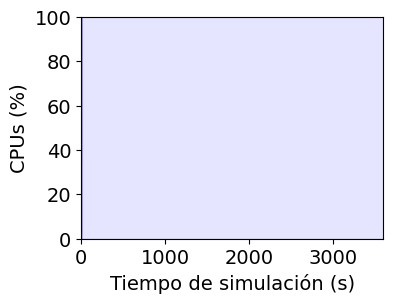

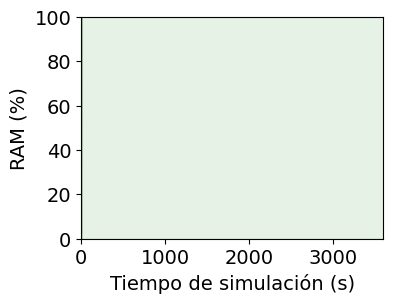

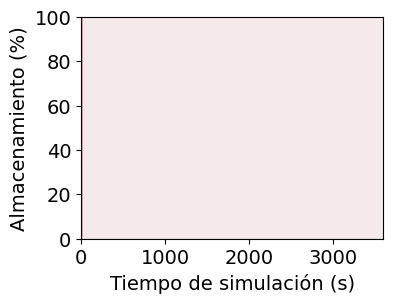

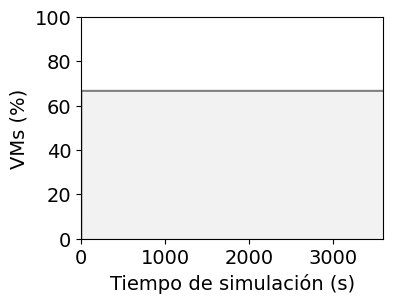

In [15]:
plot_box("bigResFogCpu1.pdf", 'CPUs (%)', res_fog["cpus"].index, (res_fog["cpus"].values / fog_max_cpus) * 100, "blue")
plot_box("bigResFogRam1.pdf", 'RAM (%)', res_fog["ram"].index, (res_fog["ram"].values / fog_max_ram) * 100, "green")
plot_box("bigResFogDisk1.pdf", 'Almacenamiento (%)', res_fog["disk"].index, (res_fog["disk"].values / fog_max_disk) * 100, "brown")
plot_box("bigResFogVms1.pdf", 'VMs (%)', res_fog["vms"].index, (res_fog["vms"].values / fog_max_vms) * 100, "gray")